**1. Setup** 

Importing the needed libraries


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Unzipping previously uploaded dataset for training.

In [ ]:
!unzip training_images.zip -d training_images

Archive:  training_images.zip
  inflating: training_images/Aaron_Eckhart/Aaron_Eckhart_0001.jpg  
  inflating: training_images/Aaron_Guiel/Aaron_Guiel_0001.jpg  
  inflating: training_images/Aaron_Patterson/Aaron_Patterson_0001.jpg  
  inflating: training_images/Aaron_Peirsol/Aaron_Peirsol_0001.jpg  
  inflating: training_images/Aaron_Peirsol/Aaron_Peirsol_0002.jpg  
  inflating: training_images/Aaron_Peirsol/Aaron_Peirsol_0003.jpg  
  inflating: training_images/Aaron_Peirsol/Aaron_Peirsol_0004.jpg  
  inflating: training_images/Aaron_Pena/Aaron_Pena_0001.jpg  
  inflating: training_images/Aaron_Sorkin/Aaron_Sorkin_0001.jpg  
  inflating: training_images/Aaron_Sorkin/Aaron_Sorkin_0002.jpg  
  inflating: training_images/Aaron_Tippin/Aaron_Tippin_0001.jpg  
  inflating: training_images/Abba_Eban/Abba_Eban_0001.jpg  
  inflating: training_images/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg  
  inflating: training_images/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg  
  inflating: trainin

In the chunk below we are:
- reading the images from the training dataset 
- looping throught the directories with images in the general directory
- converting them to grayscale 
- resizing them to the default size (250 * 250) if needed
- returning the 2d array of images and their labels


In [ ]:
DEFAULT_SIZE = [250, 250] 

def read_images(path='training_images', default_size=DEFAULT_SIZE):
    images = [] 
    labels = []
    directories = [image for image in os.listdir(path) if not image.startswith('_')]

    for img_directory in directories:
        img_path = os.path.join(path, img_directory)
        image_names = [image for image in os.listdir(img_path) if not image.startswith('.')]

        for image_name in image_names:
            image = Image.open(os.path.join(img_path, image_name))
            image = image.convert("L") # convert to greyscale
            
            # resize if needed
            if (default_size is not None):
              image = image.resize(default_size, Image.ANTIALIAS)

            images.append(np.asarray (image, dtype=np. uint8))
            labels.append(img_directory)

    return [images, labels]

Here we are representing the images as the matrix.

In the result we will have that one row of the matrix is the one image. 

In [ ]:
def as_row_matrix(img):
    # empty case
    if len(img) == 0:
        return np.array([])
    # create empty matrix
    result_matrix = np.empty((0, img[0].size), dtype = img[0].dtype)
    # fill the matrix 
    for row in img:
        result_matrix = np.vstack((result_matrix , np.asarray(row).reshape(1, -1)))

    return result_matrix

The next step is computing the mean, or average face. 


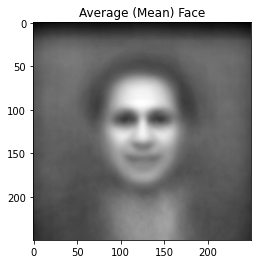

In [ ]:
[images, labels] = read_images()      
average_matrix = np.reshape(as_row_matrix(images).mean(axis=0), images[0].shape)
plt.imshow(average_matrix, cmap=plt.cm.gray)
plt.title("Average (Mean) Face")
plt.show()

In [ ]:
def components(eigenvalues, variance=.95):
    for num_components, eig_val_cs in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eig_val_cs > variance:
            return num_components
  
def pca(images, labels, numcomponents=0):
    [numrows, numcols] = images.shape

    if (numcomponents <= 0) or (numcomponents > numrows):
        numcomponents = numrows
        mu = images.mean(axis=0)
        images = images - mu

    if numrows > numcols:
        covariance_matrix = np.dot(images.T, images) 
        [eigenvalues, eigenvectors] = np.linalg.eigh(covariance_matrix)
    else :
        covariance_matrix = np.dot (images, images.T) 
        [eigenvalues, eigenvectors] = np.linalg.eigh(covariance_matrix)
        eigenvectors = np.dot(images.T, eigenvectors)
        for i in range (numrows):
            eigenvectors [:,i] = eigenvectors [:,i] / np.linalg.norm(eigenvectors [:,i])

    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    num_components = components(eigenvalues)

    # select only num_components
    eigenvalues = eigenvalues[0: num_components].copy()
    eigenvectors = eigenvectors [:, 0:num_components].copy()
    return [eigenvalues, eigenvectors, mu]  

[eigenvalues, eigenvectors, mean] = pca(as_row_matrix(images), labels)

The subplot function is used for further easier plotting.

And in this chunk we later use it to display found eigenfaces.

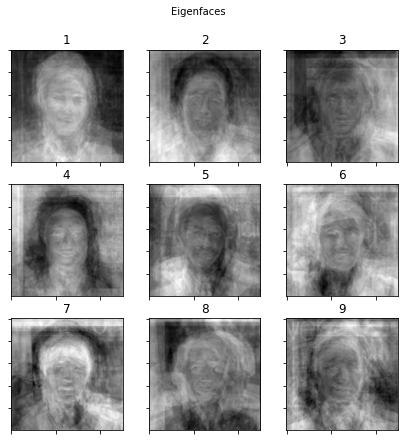

In [ ]:
def subplot(title, images, rows, cols, sptitles=[], colormap=plt.cm.gray, figsize=(7, 7)):
    fig = plt.figure(figsize = figsize)

    fig.text(.5, .95, title, horizontalalignment ="center")
    for i in range (len(images)):
        ax0 = fig.add_subplot(rows, cols, (i + 1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)

        if len(sptitles) == len(images):
            plt.title(f'{str(sptitles[i])}')
        else:
            plt.title(f'{i+1}')

        plt.imshow(np.asarray(images[i]), cmap = colormap)
    plt.show()
     
eigenfaces = []
num = eigenvectors.shape[1]
for i in range(min(num, 9)):
    eface = eigenvectors[:,i].reshape(images[0].shape)
    eigenfaces.append(np.asarray(eface))

subplot(title ="Eigenfaces", images=eigenfaces, rows=3, cols=3, colormap=plt.cm.gray)

This function is used for the projection of the images onto the pca subspace.

In [ ]:
def project(subspace, images, mu):
    return np.dot(images - mu, subspace)

In the following chunk we have two fucntions:
- dist_metric, which calculates the Euclidean distance between the points
- predict, which uses the project function to project all training samples onto the PCA subspace, and then it uses the dist_metric function to find the nearest image through

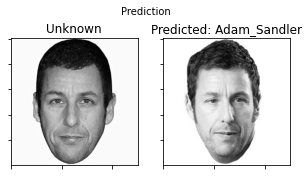

In [ ]:
def dist_metric(point1, point2):
    point1 = np.asarray(point1).flatten()
    point2 = np.asarray (point2).flatten()
    return np.sqrt(np.sum(np.power((point1 - point2), 2)))

def predict(subspace, mu , projections, y, images):
    min_dist = float("inf")
    minimum = -1
    proj = project(subspace, images.reshape(1 , -1), mu)
    for element in range(len(projections)):
        dist = dist_metric(projections[element], proj)
        if dist < min_dist:
            min_dist = dist
            minimum = element
    return minimum

projections = []
for x_i in images:
    projections.append(project(eigenvectors, x_i.reshape(1 , -1), mean))

image = Image.open('test.jpg')
image = image.convert('L') # convert unknown image to grayscale

# resize unknown image if needed
if (DEFAULT_SIZE is not None):
    image = image.resize(DEFAULT_SIZE, Image.ANTIALIAS)

test_image = np.asarray(image, dtype=np.uint8)
predicted = predict(eigenvectors, mean, projections, labels, test_image)

subplot (title ="Prediction", images =[test_image, images[predicted]], rows =1, cols =2, sptitles = ["Unknown", f'Predicted: {labels[predicted]}'], colormap=plt.cm.gray, figsize = (5,2.7))
